# 🧠 Brain Tumor Segmentation with U-Net & Attention U-Net (Showcase Notebook)
**CDTA Internship Project | Deep Learning | PyTorch**

---
This notebook demonstrates a full pipeline for brain tumor segmentation using U-Net and Attention U-Net.
Includes full training loop, Dice metric, validation, visualizations, early stopping, learning rate scheduling,
and export options for deployment.


## ⚙️ Setup and Dependencies

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('✅ Using device:', DEVICE)

✅ Using device: cuda


In [2]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA available:", torch.cuda.is_available())
print("🧠 Device:", DEVICE)


✅ CUDA available: True
🧠 Device: cuda


## 📂 Dataset: 4-Channel MRI Loader (.npy format)
Each image is a 4-channel MRI slice saved as `.npy` (shape: HxWx4)

Each mask is a 2D array (HxW) with integer labels (e.g., 0 = background, 1 = tumor)

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch
import os

class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        if not os.path.isdir(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not os.path.isdir(mask_dir):
            raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".npy")])
        self.mask_files  = sorted([f.replace("image_", "mask_") for f in self.image_files])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path  = os.path.join(self.mask_dir,  self.mask_files[idx])

        image = np.load(image_path)  # shape: (C, D, H, W) or (D, H, W, C) or similar
        mask  = np.load(mask_path)   # shape: (D, H, W)

        # If image is (D, H, W, C), move channels to front
        if image.shape[-1] == 4:     # (D, H, W, C)
            image = np.moveaxis(image, -1, 0)  # (C, D, H, W)

        image = torch.tensor(image, dtype=torch.float32)
        mask  = torch.tensor(mask, dtype=torch.long)

        return image, mask


## 🧠 U-Net 3D and Attention U-Net3D Architectures

In [4]:
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, features=[32, 64, 128, 256]):
        super(UNet3D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature
        self.bottleneck = self._block(features[-1], features[-1]*2)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature*2, feature))
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skips = skips[::-1]
        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)
            skip = skips[i//2]
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i+1](x)
        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock3D, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, features=[32, 64, 128, 256]):
        super(AttentionUNet3D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attentions = nn.ModuleList()
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature
        self.bottleneck = self._block(features[-1], features[-1]*2)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.attentions.append(AttentionBlock3D(F_g=feature, F_l=feature, F_int=feature//2))
            self.decoder.append(self._block(feature*2, feature))
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skips = skips[::-1]
        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)
            skip = skips[i//2]
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            skip = self.attentions[i//2](g=x, x=skip)
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i+1](x)
        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )


## 🔀 Dataset Split: Train & Validation
We use an 80/20 split to train and evaluate performance.

In [6]:
dataset = BrainTumorDataset(
    r"D:\Khedir-meriem-ESI-SBElAbes\data\input_data_4channels_z_score\train\images",
    r"D:\Khedir-meriem-ESI-SBElAbes\data\input_data_4channels_z_score\train\masks",
)

print("Total samples:", len(dataset))
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=1,            # Use 2 for 3D models (adjust if OOM or slow)
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,            # Same as above
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Total samples: 2547
Image shape: torch.Size([4, 192, 192, 128])
Mask shape: torch.Size([192, 192, 128])


In [7]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## 📐 Dice Coefficient Metric
Used to evaluate how well the predicted segmentation matches the ground truth.

In [8]:
def dice_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred == target).float().sum()
    dice = (2. * intersection) / (pred.numel() + target.numel() + eps)
    return dice


## 🧪 Training Function (AMP + EarlyStopping + Scheduler)

In [9]:

from torch.cuda.amp import autocast, GradScaler
import csv

def train_model(model, name):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss()

    scaler = GradScaler()
    best_dice = 0
    patience = 10
    trigger = 0
    train_dice, val_dice = [], []

    # Prepare CSV log file
    log_path = f"{name}_log.csv"
    with open(log_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "TrainLoss", "ValDice"])

    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()

            with autocast():
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # Validation
        model.eval()
        dice = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                with autocast():
                    pred = torch.argmax(model(x), dim=1)
                dice += dice_coeff(pred.cpu(), y.cpu())
        avg_dice = dice / len(val_loader)
        val_dice.append(avg_dice.item())

        # Log to CSV
        with open(log_path, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch, total_loss, avg_dice.item()])

        print(f"[{name}] Epoch {epoch}, Loss: {total_loss:.4f}, Val Dice: {avg_dice:.4f}")
        scheduler.step(total_loss)

        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), f"{name}_best.pth")
            print(f"✅ Saved best model with Dice: {best_dice:.4f}")
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # After training: plot Dice scores
    plt.figure(figsize=(8, 5))
    plt.plot(val_dice, label='Validation Dice')
    plt.xlabel("Epoch")
    plt.ylabel("Dice Coefficient")
    plt.title(f"Validation Dice Curve ({name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{name}_dice_plot.png")
    plt.show()


In [10]:
model = UNet3D().to(DEVICE)
print("🔥 Is model on GPU?", next(model.parameters()).is_cuda)


🔥 Is model on GPU? True


## 🧠 Train Both Models (100 Epochs Max + Early Stopping)

Epoch 1: 100%|██████████| 2037/2037 [26:11<00:00,  1.30it/s]


[unet3d] Epoch 1, Loss: 396.3700, Val Dice: 0.9923
✅ Saved best model with Dice: 0.9923


Epoch 2: 100%|██████████| 2037/2037 [25:45<00:00,  1.32it/s]


[unet3d] Epoch 2, Loss: 55.0269, Val Dice: 0.9938
✅ Saved best model with Dice: 0.9938


Epoch 3: 100%|██████████| 2037/2037 [26:12<00:00,  1.30it/s]


[unet3d] Epoch 3, Loss: 34.8193, Val Dice: 0.9893


Epoch 4: 100%|██████████| 2037/2037 [26:12<00:00,  1.30it/s]


[unet3d] Epoch 4, Loss: 28.4035, Val Dice: 0.9931


Epoch 5: 100%|██████████| 2037/2037 [25:52<00:00,  1.31it/s]


[unet3d] Epoch 5, Loss: 26.2917, Val Dice: 0.9916


Epoch 6: 100%|██████████| 2037/2037 [25:38<00:00,  1.32it/s]


[unet3d] Epoch 6, Loss: 23.8114, Val Dice: 0.9895


Epoch 7: 100%|██████████| 2037/2037 [24:46<00:00,  1.37it/s]


[unet3d] Epoch 7, Loss: 23.4109, Val Dice: 0.9928


Epoch 8: 100%|██████████| 2037/2037 [25:11<00:00,  1.35it/s]


[unet3d] Epoch 8, Loss: 21.9531, Val Dice: 0.9940
✅ Saved best model with Dice: 0.9940


Epoch 9: 100%|██████████| 2037/2037 [25:10<00:00,  1.35it/s]


[unet3d] Epoch 9, Loss: 21.3884, Val Dice: 0.9928


Epoch 10: 100%|██████████| 2037/2037 [25:10<00:00,  1.35it/s]


[unet3d] Epoch 10, Loss: 20.7721, Val Dice: 0.9930


Epoch 11: 100%|██████████| 2037/2037 [25:15<00:00,  1.34it/s]


[unet3d] Epoch 11, Loss: 20.1535, Val Dice: 0.9939


Epoch 12: 100%|██████████| 2037/2037 [25:08<00:00,  1.35it/s]


[unet3d] Epoch 12, Loss: 19.9887, Val Dice: 0.9928


Epoch 13: 100%|██████████| 2037/2037 [25:10<00:00,  1.35it/s]


[unet3d] Epoch 13, Loss: 19.6438, Val Dice: 0.9882


Epoch 14: 100%|██████████| 2037/2037 [25:13<00:00,  1.35it/s]


[unet3d] Epoch 14, Loss: 19.0436, Val Dice: 0.9913


Epoch 15: 100%|██████████| 2037/2037 [25:35<00:00,  1.33it/s]


[unet3d] Epoch 15, Loss: 18.6429, Val Dice: 0.9925


Epoch 16: 100%|██████████| 2037/2037 [25:33<00:00,  1.33it/s]


[unet3d] Epoch 16, Loss: 18.5858, Val Dice: 0.9943
✅ Saved best model with Dice: 0.9943


Epoch 17: 100%|██████████| 2037/2037 [25:31<00:00,  1.33it/s]


[unet3d] Epoch 17, Loss: 18.6824, Val Dice: 0.9928


Epoch 18: 100%|██████████| 2037/2037 [25:21<00:00,  1.34it/s]


[unet3d] Epoch 18, Loss: 17.5846, Val Dice: 0.9935


Epoch 19: 100%|██████████| 2037/2037 [24:46<00:00,  1.37it/s]


[unet3d] Epoch 19, Loss: 17.7214, Val Dice: 0.9944
✅ Saved best model with Dice: 0.9944


Epoch 20: 100%|██████████| 2037/2037 [24:47<00:00,  1.37it/s]


[unet3d] Epoch 20, Loss: 17.0509, Val Dice: 0.9942


Epoch 21: 100%|██████████| 2037/2037 [24:46<00:00,  1.37it/s]


[unet3d] Epoch 21, Loss: 16.9228, Val Dice: 0.9855


Epoch 22: 100%|██████████| 2037/2037 [24:46<00:00,  1.37it/s]


[unet3d] Epoch 22, Loss: 16.4039, Val Dice: 0.9938


Epoch 23: 100%|██████████| 2037/2037 [24:48<00:00,  1.37it/s]


[unet3d] Epoch 23, Loss: 15.9458, Val Dice: 0.9932


Epoch 24: 100%|██████████| 2037/2037 [24:47<00:00,  1.37it/s]


[unet3d] Epoch 24, Loss: 15.8261, Val Dice: 0.9949
✅ Saved best model with Dice: 0.9949


Epoch 25: 100%|██████████| 2037/2037 [24:47<00:00,  1.37it/s]


[unet3d] Epoch 25, Loss: 15.3418, Val Dice: 0.9939


Epoch 26: 100%|██████████| 2037/2037 [24:47<00:00,  1.37it/s]


[unet3d] Epoch 26, Loss: 15.3358, Val Dice: 0.9925


Epoch 27: 100%|██████████| 2037/2037 [24:46<00:00,  1.37it/s]


[unet3d] Epoch 27, Loss: 15.0309, Val Dice: 0.9896


Epoch 28: 100%|██████████| 2037/2037 [24:47<00:00,  1.37it/s]


[unet3d] Epoch 28, Loss: 15.2182, Val Dice: 0.9932


Epoch 29: 100%|██████████| 2037/2037 [24:47<00:00,  1.37it/s]


[unet3d] Epoch 29, Loss: 14.5060, Val Dice: 0.9950
✅ Saved best model with Dice: 0.9950


Epoch 30: 100%|██████████| 2037/2037 [24:48<00:00,  1.37it/s]


[unet3d] Epoch 30, Loss: 14.4801, Val Dice: 0.9922


Epoch 31: 100%|██████████| 2037/2037 [24:49<00:00,  1.37it/s]


[unet3d] Epoch 31, Loss: 14.4229, Val Dice: 0.9950
✅ Saved best model with Dice: 0.9950


Epoch 32: 100%|██████████| 2037/2037 [25:15<00:00,  1.34it/s]


[unet3d] Epoch 32, Loss: 14.1294, Val Dice: 0.9897


Epoch 33: 100%|██████████| 2037/2037 [24:52<00:00,  1.37it/s]


[unet3d] Epoch 33, Loss: 14.4575, Val Dice: 0.9919


Epoch 34: 100%|██████████| 2037/2037 [24:47<00:00,  1.37it/s]


[unet3d] Epoch 34, Loss: 13.8863, Val Dice: 0.9947


Epoch 35: 100%|██████████| 2037/2037 [24:49<00:00,  1.37it/s]


[unet3d] Epoch 35, Loss: 13.8885, Val Dice: 0.9901


Epoch 36: 100%|██████████| 2037/2037 [24:49<00:00,  1.37it/s]


[unet3d] Epoch 36, Loss: 13.5503, Val Dice: 0.9900


Epoch 37: 100%|██████████| 2037/2037 [24:50<00:00,  1.37it/s]


[unet3d] Epoch 37, Loss: 13.3879, Val Dice: 0.9901


Epoch 38: 100%|██████████| 2037/2037 [24:50<00:00,  1.37it/s]


[unet3d] Epoch 38, Loss: 13.2701, Val Dice: 0.9914


Epoch 39: 100%|██████████| 2037/2037 [24:50<00:00,  1.37it/s]


[unet3d] Epoch 39, Loss: 13.1891, Val Dice: 0.9947


Epoch 40: 100%|██████████| 2037/2037 [24:48<00:00,  1.37it/s]


[unet3d] Epoch 40, Loss: 13.1408, Val Dice: 0.9925


Epoch 41: 100%|██████████| 2037/2037 [25:00<00:00,  1.36it/s]


[unet3d] Epoch 41, Loss: 12.9372, Val Dice: 0.9715
⏹️ Early stopping triggered.


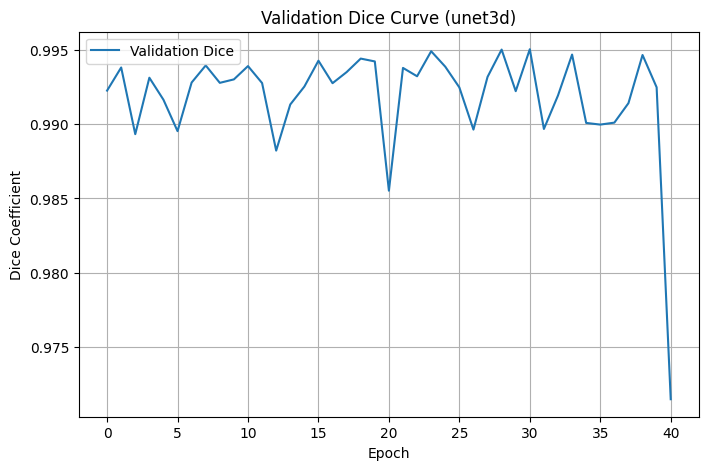

In [11]:
# Make sure the cell defining train_model is run before this cell.
train_model(UNet3D(), "unet3d")

Epoch 1: 100%|██████████| 2037/2037 [27:41<00:00,  1.23it/s]


[att_unet3d] Epoch 1, Loss: 445.5894, Val Dice: 0.9925
✅ Saved best model with Dice: 0.9925


Epoch 2: 100%|██████████| 2037/2037 [28:03<00:00,  1.21it/s]


[att_unet3d] Epoch 2, Loss: 59.2261, Val Dice: 0.9937
✅ Saved best model with Dice: 0.9937


Epoch 3: 100%|██████████| 2037/2037 [28:05<00:00,  1.21it/s]


[att_unet3d] Epoch 3, Loss: 33.1423, Val Dice: 0.9936


Epoch 4: 100%|██████████| 2037/2037 [28:08<00:00,  1.21it/s]


[att_unet3d] Epoch 4, Loss: 27.5493, Val Dice: 0.9926


Epoch 5: 100%|██████████| 2037/2037 [27:30<00:00,  1.23it/s]


[att_unet3d] Epoch 5, Loss: 24.7131, Val Dice: 0.9944
✅ Saved best model with Dice: 0.9944


Epoch 6: 100%|██████████| 2037/2037 [27:15<00:00,  1.25it/s]


[att_unet3d] Epoch 6, Loss: 23.7996, Val Dice: 0.9949
✅ Saved best model with Dice: 0.9949


Epoch 7: 100%|██████████| 2037/2037 [28:19<00:00,  1.20it/s]


[att_unet3d] Epoch 7, Loss: 22.2923, Val Dice: 0.9940


Epoch 8: 100%|██████████| 2037/2037 [28:13<00:00,  1.20it/s]


[att_unet3d] Epoch 8, Loss: 22.1384, Val Dice: 0.9930


Epoch 9: 100%|██████████| 2037/2037 [28:59<00:00,  1.17it/s]


[att_unet3d] Epoch 9, Loss: 20.8454, Val Dice: 0.9940


Epoch 10: 100%|██████████| 2037/2037 [28:58<00:00,  1.17it/s]


[att_unet3d] Epoch 10, Loss: 20.3918, Val Dice: 0.9925


Epoch 11: 100%|██████████| 2037/2037 [28:50<00:00,  1.18it/s]


[att_unet3d] Epoch 11, Loss: 20.4605, Val Dice: 0.9943


Epoch 12: 100%|██████████| 2037/2037 [28:38<00:00,  1.19it/s]


[att_unet3d] Epoch 12, Loss: 19.7197, Val Dice: 0.9946


Epoch 13: 100%|██████████| 2037/2037 [28:37<00:00,  1.19it/s]


[att_unet3d] Epoch 13, Loss: 19.4122, Val Dice: 0.9943


Epoch 14: 100%|██████████| 2037/2037 [27:58<00:00,  1.21it/s]


[att_unet3d] Epoch 14, Loss: 19.1117, Val Dice: 0.9918


Epoch 15: 100%|██████████| 2037/2037 [27:46<00:00,  1.22it/s]


[att_unet3d] Epoch 15, Loss: 18.7111, Val Dice: 0.9947


Epoch 16: 100%|██████████| 2037/2037 [28:32<00:00,  1.19it/s]


[att_unet3d] Epoch 16, Loss: 18.2966, Val Dice: 0.9948
⏹️ Early stopping triggered.


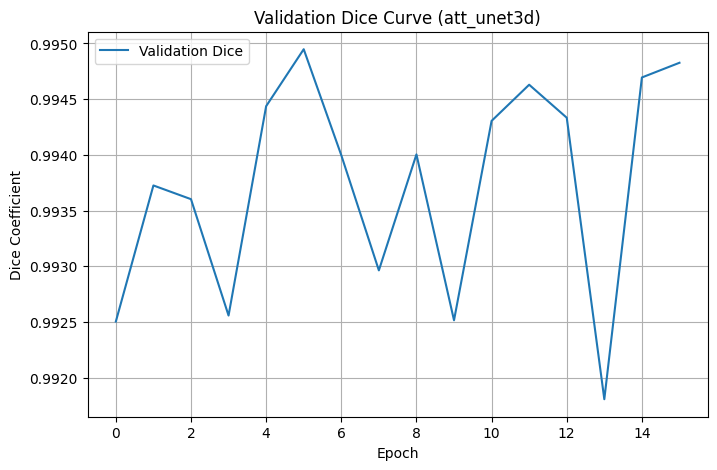

In [12]:
# After that finishes
train_model(AttentionUNet3D(), "att_unet3d")

## 📊 Plot Dice Score Over Epochs

In [ ]:
plt.plot(train_size, label='Train Dice')
plt.plot(val_size, label='Val Dice')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Training Curve')
plt.show()

## 🔍 Visualize Predictions

In [ ]:
def visualize_predictions(model_path, model_class):
    model = model_class().to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        pred = torch.argmax(model(x), dim=1)

    # Show first slice of first 3 volumes
    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(3, 3, i*3+1); plt.imshow(x[i][0, 0].cpu(), cmap='gray'); plt.title('Input (slice 0)')
        plt.subplot(3, 3, i*3+2); plt.imshow(y[i][0].cpu(), cmap='gray'); plt.title('GT (slice 0)')
        plt.subplot(3, 3, i*3+3); plt.imshow(pred[i][0].cpu(), cmap='gray'); plt.title('Prediction (slice 0)')
    plt.tight_layout(); plt.show()

visualize_predictions("unet3d_best.pth", UNet3D)
visualize_predictions("att_unet3d_best.pth", AttentionUNet3D)

## 💾 Export Models: TorchScript + ONNX

In [ ]:
dummy = torch.randn(1, 4, 64, 128, 128).to(DEVICE)  # Adjust shape to your 3D input
model = AttentionUNet3D().to(DEVICE)
model.load_state_dict(torch.load("att_unet3d_best.pth"))
torch.jit.trace(model, dummy).save("attention_unet3d.pt")
torch.onnx.export(model, dummy, "attention_unet3d.onnx", input_names=["input"], output_names=["output"], opset_version=11)
print("✅ Exported to .pt and .onnx")

## ✅ Summary & Deployment Tips
- Best Dice model saved as `.pth`
- Deployment-ready formats: `.pt` (TorchScript), `.onnx`
- Use ONNX for ONNX Runtime, TensorRT, or OpenVINO.
- Ideal for mobile, embedded, or web deployment.

**Next step:** Try converting the ONNX model into TensorRT or integrating in a simple Flask demo.

## 🧪 Advanced Data Augmentation with Albumentations
We use Albumentations to apply more realistic and effective augmentations during training.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

class AugmentedBrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augment=False):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.npy')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.npy')))
        self.augment = augment
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx]).astype(np.float32)
        mask = np.load(self.mask_paths[idx]).astype(np.uint8)
        image = image.transpose(2, 0, 1)  # [C, H, W]
        if self.augment:
            augmented = self.transform(image=image.transpose(1, 2, 0), mask=mask)
            image, mask = augmented['image'], augmented['mask']
        else:
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

In [ ]:
# Replace old dataset and reload
dataset = AugmentedBrainTumorDataset(
    r"D:\Khedir-meriem-ESI-SBElAbes\data\input_data_4channels_z_score\train\images",
    r"D:\Khedir-meriem-ESI-SBElAbes\data\input_data_4channels_z_score\train\masks"
    augment=True
)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

## 🔗 Ensemble Prediction: U-Net + Attention U-Net
Combines predictions from both models to potentially improve segmentation accuracy.

In [ ]:
def ensemble_predict(x):
    model1 = UNet3D().to(DEVICE)
    model1.load_state_dict(torch.load("unet3d_best.pth"))
    model2 = AttentionUNet3D().to(DEVICE)
    model2.load_state_dict(torch.load("att_unet3d_best.pth"))
    model1.eval(); model2.eval()

    with torch.no_grad():
        out1 = model1(x)
        out2 = model2(x)
        avg_out = (out1 + out2) / 2
        pred = torch.argmax(avg_out, dim=1)
    return pred

In [ ]:
x, y = next(iter(val_loader))
x, y = x.to(DEVICE), y.to(DEVICE)
pred = ensemble_predict(x)

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(3, 3, i*3+1); plt.imshow(x[i][0, 0].cpu(), cmap='gray'); plt.title('Input (slice 0)')
    plt.subplot(3, 3, i*3+2); plt.imshow(y[i][0].cpu(), cmap='gray'); plt.title('Ground Truth (slice 0)')
    plt.subplot(3, 3, i*3+3); plt.imshow(pred[i][0].cpu(), cmap='gray'); plt.title('Ensemble Pred (slice 0)')
plt.tight_layout(); plt.show()